In [ ]:
import json
from pathlib import Path
import pandas as pd

# notebook is in /notebooks so ../data/raw should work
DATA_DIR = Path("../data/raw")
EVENT_DIR = DATA_DIR / "event_data" / "May 1, 2025"

EVENT_DIR.exists(), EVENT_DIR

In [ ]:
event_files = sorted(EVENT_DIR.glob("*.json"))
len(event_files), event_files[:3]

In [ ]:
import json

sample_path = event_files[0]
sample_path
with open(sample_path, "r") as f:
    raw = json.load(f)

type(raw)
len(raw) if isinstance(raw, list) else list(raw.keys())

In [ ]:
df = pd.json_normalize(raw)
df.shape
df.columns.tolist()[:40]

In [ ]:
core_cols = [
    "gameId",
    "possessionEventId",
    "eventTime",
    "startTime",
    "endTime",
    "duration",
    "sequence",
    "gameEvents.gameEventType",
    "gameEvents.period",
    "gameEvents.teamId",
    "gameEvents.teamName",
    "gameEvents.playerId",
    "gameEvents.playerName",
    "gameEvents.subType",
    "gameEvents.endType",
    "gameEvents.outType",
]

core = df[core_cols].copy()

core = core.rename(columns={
    "gameId": "match_id",
    "possessionEventId": "possession_id",
    "eventTime": "t",
    "gameEvents.gameEventType": "event_type",
    "gameEvents.period": "period",
    "gameEvents.teamId": "team_id",
    "gameEvents.teamName": "team_name",
    "gameEvents.playerId": "player_id",
    "gameEvents.playerName": "player_name",
    "gameEvents.subType": "subtype",
    "gameEvents.endType": "end_type",
    "gameEvents.outType": "out_type",
})

core.head(10)

In [ ]:
core["possession_id"].nunique(), core.groupby("possession_id")["event_type"].size().describe()

In [ ]:
core = core.sort_values(["match_id", "t"]).reset_index(drop=True)

core["possession_id"] = core["possession_id"].ffill()

core[["t", "event_type", "possession_id"]].head(10)

## Possession Segmentation – Notes on Data Structure

### Raw Event Structure
Each match event file contains roughly 2,000–2,500 rows, but these rows don’t map one-to-one with actual soccer actions.

Instead, the data alternates between:
- **Wrapper / control rows** (e.g. `OTB`, `OUT`)
- **Actual on-ball events**, which include a `possessionEventId`

Because of this:
- `possessionEventId` is missing (`NaN`) on many rows
- The possession ID only appears on the “real” event row, not the preceding wrapper row

---

### Possession ID Normalization
To correctly assign every row to a possession, the events were:
1. Sorted by match and event time  
2. Forward-filled (`ffill`) on the `possessionEventId` column  

This associates wrapper rows with the correct possession context.

After this step:
- Possessions typically contain **1–6 events**
- The median possession length is **~2 events**
- The total number of possessions per match looks reasonable

This confirms that `possessionEventId` is a valid native possession identifier once normalized.

---

### Key Observation
Possession structure is already encoded in the data, but it’s not immediately usable due to the presence of alternating non-event rows.

Without forward-filling the possession ID, possession-level analysis becomes misleading (e.g., all possessions appearing to have only a single event).

---

### Current Scope and Assumptions
- Analysis is currently based on **event-level data only**
- Wrapper events (`OTB`, `OUT`, etc.) are kept to preserve timing and sequence information
- Substitution-aware on-pitch filtering has not yet been applied and will be handled in a later pass

This preprocessing step sets up reliable downstream analysis, including:
- Possession duration
- Action sequences within possessions
- Shot-ending possessions
- Early tactical buildup patterns

In [ ]:
#investigate where shots live
#core["event_type"].value_counts().head(15)
#core[
   #core["subtype"].notna() | core["end_type"].notna()
#][["event_type", "subtype", "end_type", "out_type"]].head(20)
# show columns that look action-related
[action for action in df.columns if "type" in action.lower()][:30]

# find a row that is not OTB or OUT
mask = ~df["gameEvents.gameEventType"].isin(["OTB", "OUT"])
df[mask].iloc[0].to_dict()

In [ ]:
core["action_type"] = df["possessionEvents.possessionEventType"]
core["action_type"].value_counts().head(15)
#confirm where shots live and get a sense of other action types, as well as how they are
# presented

In [ ]:
core["is_shot"] = core["action_type"] == "SH"
core[["action_type", "is_shot"]].value_counts().head(10)
possession_summary = (
    core
    .groupby("possession_id")
    .agg(
        match_id=("match_id", "first"),
        team_id=("team_id", "first"),
        team_name=("team_name", "first"),
        start_time=("t", "min"),
        end_time=("t", "max"),
        n_events=("action_type", "size"),
        n_passes=("action_type", lambda x: (x == "PA").sum()),
        ended_in_shot=("is_shot", "any"),
    )
    .reset_index()
)

possession_summary.head()

In [ ]:
possession_summary["ended_in_shot"].value_counts(normalize=True)
#confirm ballpark percentages of possessions ending in shots

## Possessions Ending in Shots – Initial Findings

Using the normalized `possessionEventId` and action-level data from `possessionEvents`, we label each possession based on whether it contains a shot event (`action_type == "SH"`).

### Shot Identification
- Shot actions are explicitly encoded as `possessionEvents.possessionEventType == "SH"`
- No heuristic inference is required for shot detection

### Possession-Level Labeling
A possession is labeled as **shot-ending** if **any** event within that possession is a shot.

For this match:
- **~2.2% of possessions end in a shot**
- **~97.8% of possessions do not result in a shot**

This aligns with expectations for event-level possession segmentation, where many possessions are short and end in turnovers or resets.

### Interpretation
The strong class imbalance highlights that:
- Most possessions are low-threat
- Shot-ending possessions represent a small, high-value subset

This supports using possession-level features (e.g., duration, pass count, action sequencing) to distinguish *dangerous* possessions from routine ball circulation.

### Next Step
We now compare **shot-ending vs non-shot possessions** to identify tactical patterns that increase the likelihood of a possession producing a shot.

In [ ]:
possession_summary["duration"] = (
    possession_summary["end_time"] - possession_summary["start_time"]
)

possession_summary[["duration", "n_events", "n_passes"]].describe()

In [ ]:
(
    possession_summary
    .groupby("ended_in_shot")[["duration", "n_events", "n_passes"]]
    .mean()
)

In [ ]:
(
    possession_summary
    .groupby("ended_in_shot")[["duration", "n_events", "n_passes"]]
    .median()
)

In [ ]:
shot = possession_summary[possession_summary["ended_in_shot"]]
non  = possession_summary[~possession_summary["ended_in_shot"]]

(pd.concat([
    shot[["duration", "n_events", "n_passes"]].mean(),
    non[["duration", "n_events", "n_passes"]].mean()
], axis=1, keys=["shot", "non_shot"])
 .assign(ratio=lambda x: x["shot"] / x["non_shot"])
)

## Shot vs Non-Shot Possessions – Early Comparison

We compare basic possession-level features between possessions that end in a shot and those that do not.

### Key Findings

**1. Possession Duration**
- Shot-ending possessions are about **6× longer** on average than non-shot possessions.
- This suggests that sustained control is a strong prerequisite for generating shots.
- While medians are similar, the **upper tail** of long possessions is where shot creation occurs.

**2. Number of Actions**
- Shot-ending possessions involve slightly more actions on average.
- However, the difference is modest, indicating that *sequence quality* matters more than raw action count.

**3. Pass Count Interpretation**
- Shot-ending possessions show fewer logged pass actions.
- This is likely due to schema effects, where:
  - crosses, carries, or initial touches are logged as separate action types
  - the final action before a shot is often not a standard pass

This highlights the importance of considering **all on-ball actions**, not just passes, when modeling danger buildup.

### Takeaway
Duration is the clearest early indicator of possession danger. Future analysis should focus on:
- action sequencing
- temporal buildup immediately before shots
- role of non-pass actions (carries, crosses) in shot creation

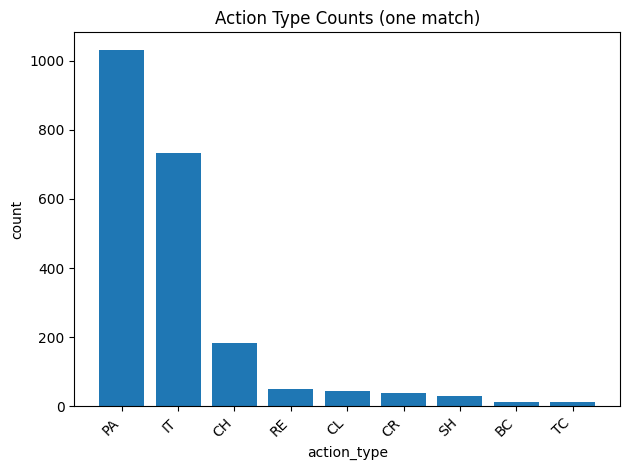

In [33]:
import matplotlib.pyplot as plt

counts = core["action_type"].value_counts().sort_values(ascending=False)

plt.figure()
plt.bar(counts.index.astype(str), counts.values)
plt.title("Action Type Counts (one match)")
plt.xlabel("action_type")
plt.ylabel("count")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

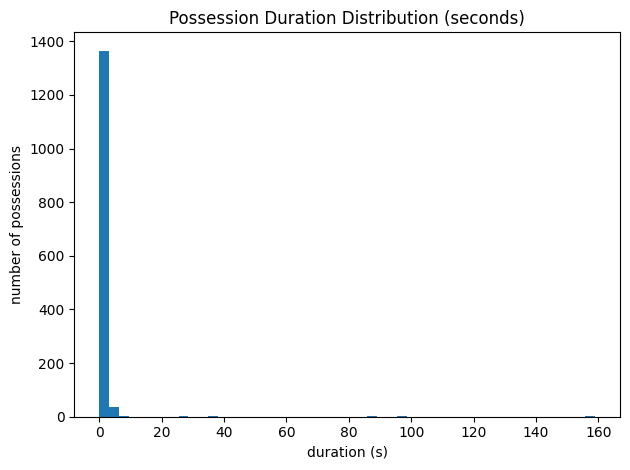

In [30]:
plt.figure()
plt.hist(possession_summary["duration"], bins=50)
plt.title("Possession Duration Distribution (seconds)")
plt.xlabel("duration (s)")
plt.ylabel("number of possessions")
plt.tight_layout()
plt.show()

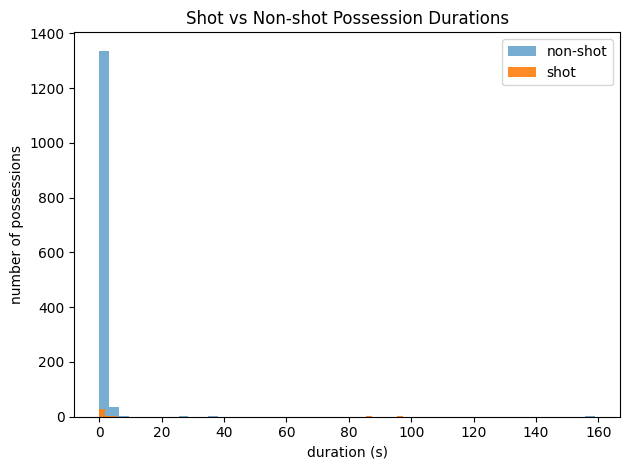

In [31]:
shot = possession_summary[possession_summary["ended_in_shot"]]["duration"]
non  = possession_summary[~possession_summary["ended_in_shot"]]["duration"]

plt.figure()
plt.hist(non, bins=50, alpha=0.6, label="non-shot")
plt.hist(shot, bins=50, alpha=0.9, label="shot")
plt.title("Shot vs Non-shot Possession Durations")
plt.xlabel("duration (s)")
plt.ylabel("number of possessions")
plt.legend()
plt.tight_layout()
plt.show()

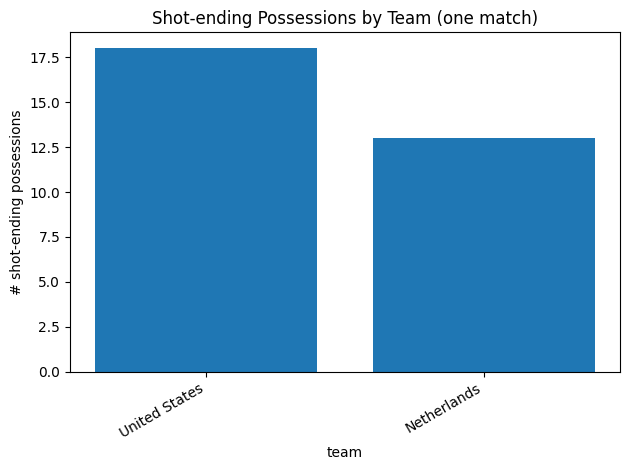

In [32]:
shots_by_team = (
    possession_summary[possession_summary["ended_in_shot"]]
    .groupby("team_name")["possession_id"]
    .nunique()
    .sort_values(ascending=False)
)

plt.figure()
plt.bar(shots_by_team.index.astype(str), shots_by_team.values)
plt.title("Shot-ending Possessions by Team (one match)")
plt.xlabel("team")
plt.ylabel("# shot-ending possessions")
plt.xticks(rotation=30, ha="right")
plt.tight_layout()
plt.show()

## Summary of Key EDA Plots

**Plot 1 - Count of actions**
This bar chart shows the amount of actions per subsection in during one average game. 

**Plot 2 – Possession Duration Distribution**  
This histogram shows the distribution of possession durations. Most possessions are very short (1–2 seconds), with a long right tail representing sustained buildup phases. This confirms that possessions are correctly segmented and highlights the imbalance between routine and extended possessions.

**Plot 3 – Shot vs Non-shot Possession Durations**  
Comparing shot-ending and non-shot possessions shows that shot-ending possessions tend to last longer and populate the upper tail of the distribution. While most possessions are short, sustained possessions are more likely to result in shots, making duration a strong early indicator of danger.

**Plot 4 – Shot-ending Possessions by Team**  
This bar chart shows the number of possessions that resulted in a shot for each team in the match. It provides a simple team-level view of which side generated more dangerous possessions and validates possession-level aggregation by team.